In [25]:
import os
from pathlib import Path
import urllib

import datetime
import numpy as np
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
from matplotlib import patches
import spiceypy as spice
from PIL import Image
import numpy.linalg as LA


from surrender.geometry import vec3, vec4, quat, normalize, QuatToMat, MatToQuat, gaussian
from surrender.surrender_client import surrender_client
from craterdetection.matching.database import extract_robbins_dataset, load_craters
from craterdetection.matching.projective_invariants import crater_representation, matrix_adjugate

_BASE_URL = 'https://naif.jpl.nasa.gov/pub/naif/'
_KERNEL_ROOT = Path('../data/spice_kernels')

# Constants:
sun_radius = 696342000
ua2km = 149597870.700
ua = ua2km * 1000
R_moon = 1737.4


In [3]:
def download_kernel(file_path, base_url=_BASE_URL, base_folder=_KERNEL_ROOT):
    if isinstance(file_path, str):
        file_path = Path(file_path)

    local_path = base_folder / file_path
    url = base_url + file_path.as_posix()

    # Create necessary sub-directories in the DL_PATH direction
    local_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        # If the file is not present in the download directory -> download it
        if not os.path.isfile(local_path):
            print(f"Downloading {url}", end="  ")
            # Download the file with the urllib  package
            urllib.request.urlretrieve(str(url), str(local_path))
            print("Done.")
        else:
            print(f"{base_folder / file_path} already exists!")
    except urllib.error.HTTPError as e:
        print(f"Error: \n{url} could not be found: ", e)

In [4]:
kernels = list(map(Path, [
    'generic_kernels/lsk/naif0012.tls',
    'generic_kernels/pck/pck00010.tpc',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/spk/de421.bsp',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/pck/moon_pa_de421_1900_2050.bpc',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_assoc_pa.tf',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_080317.tf'
]))

In [5]:
for k in kernels:
    download_kernel(k)

spice.furnsh(map(str, list(map(lambda x: _KERNEL_ROOT / x, kernels))))

..\data\spice_kernels\generic_kernels\lsk\naif0012.tls already exists!
..\data\spice_kernels\generic_kernels\pck\pck00010.tpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\spk\de421.bsp already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\pck\moon_pa_de421_1900_2050.bpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_assoc_pa.tf already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_080317.tf already exists!


In [26]:
# Image setup:
fov = 45
raytracing = False
N = [1000, 1000]
rays = 32

# set PSF
surech_PSF = 5
sigma = 1
wPSF = 5
PSF = gaussian(wPSF * surech_PSF, sigma * surech_PSF)

## Initializing SurRender
s = surrender_client()
s.setVerbosityLevel(2)
s.connectToServer('127.0.0.1')
s.setCompressionLevel(0)
s.closeViewer()
s.setTimeOut(86400)
s.setShadowMapSize(4096)
s.setCubeMapSize(4096)
s.enableMultilateralFiltering(True)
s.enablePreviewMode(True)
s.enableDoublePrecisionMode(True)
s.enableRaytracing(raytracing)

s.setConventions(s.SCALAR_XYZ_CONVENTION, s.Z_FRONTWARD)
s.setPSF(PSF, wPSF, wPSF)

if raytracing:
    s.enableFastPSFMode(False)
    s.enableRaytracing(True)
    s.enableIrradianceMode(False)
    s.setNbSamplesPerPixel(rays)  # Raytracing
    s.enableRegularPSFSampling(True)
    s.enablePathTracing(False)
else:
    s.enableFastPSFMode(True)
    s.enableRaytracing(False)
    s.enableIrradianceMode(False)
    s.enablePathTracing(False)

s.createBRDF('sun', 'sun.brdf', {})
s.createShape('sun', 'sphere.shp', {'radius': sun_radius})
s.createBody('sun', 'sun', 'sun', [])

s.createBRDF('hapke', 'hapke.brdf', {})
s.createSphericalDEM('moon', 'Moon_LRO.dem', 'hapke', 'moon.jpg')
s.setObjectElementBRDF('moon', 'moon', 'hapke')

s.setCameraFOVDeg(fov, np.arctan(np.tan(fov / 360 * np.pi) * N[1] / N[0]) * 360 / np.pi)
s.setImageSize(N[0], N[1])

s.setSunPower(10 * ua * ua * np.pi * 5.2 * 5.2 * vec4(1, 1, 1, 1))

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [27]:
# convert the datetime to a string, replacing the time with midnight
DATE = '2020-12-01T00:00:00'

# convert the utc midnight string to the corresponding ET
ET_DATE = spice.utc2et(DATE)

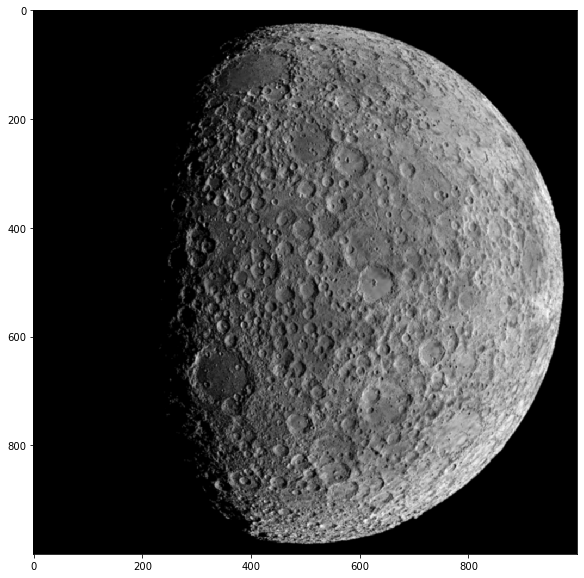

In [28]:
MOON_POS = vec3(0, 0, 0)

SUN_POS_REL_MOON, _ = spice.spkpos(targ='SUN', et=ET_DATE, ref='ECLIPJ2000', abcorr='NONE', obs='MOON')
SUN_POS_REL_MOON *= 1e3  # Convert to m

EARTH_POS_REL_MOON, _ = spice.spkpos(targ='EARTH', et=ET_DATE, ref='ECLIPJ2000', abcorr='NONE', obs='MOON')
EARTH_POS_REL_MOON *= 1e3  # Convert to m

EARTH_ROT_REL_MOON = spice.pxform("MOON_PA", "IAU_EARTH", ET_DATE)

dist = R_moon*1e3 + 3000e3

Rcam = np.eye(3)
r = R.from_euler('y', 90, degrees=True)
r = r * R.from_euler('z', -90, degrees=True)
T_MC = r.as_matrix()
Rcam = Rcam @ T_MC
Xcam = np.array([-dist, 0, 0])
s.setObjectPosition('camera', Xcam)
s.setObjectAttitude('camera', MatToQuat(Rcam))
s.setObjectPosition('sun', SUN_POS_REL_MOON)
s.setObjectPosition('moon', MOON_POS)

R_ast = np.eye(3)
R_ast = QuatToMat(quat(vec3(0, 0, 1), np.pi / 2)) @ R_ast
R_ast = QuatToMat(quat(vec3(1, 0, 0), (90 - 11) / 180 * np.pi)) @ R_ast
R_ast = QuatToMat(quat(vec3(0, 1, 0), -0 - np.pi / 3)) @ R_ast
s.setObjectAttitude('moon', MatToQuat(R_ast))

s.render()
im = s.getImageGray32F()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, aspect='equal', interpolation='none', cmap='gray')

In [29]:
lat, long, major, minor, psi, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[100, 500])
)

### Mathematical Representation of a Crater
#### Convert coordinates to 3D selenographic position

In [30]:
p_Mi = R_moon*np.array([
    np.cos(lat)*np.cos(long),
    np.cos(lat)*np.sin(long),
    np.sin(lat)
]).T[:, :, None]

#### Define local ENU coordinate system

In [31]:
k = np.array([0, 0, 1])[:, None]
print(k.shape)

u_i = p_Mi / R_moon

e_i = np.cross(k.squeeze(), u_i.squeeze())[:, :, None]
e_i /= LA.norm(e_i, ord=2, axis=(1,2))[:, None, None]

n_i = np.cross(u_i.squeeze(), e_i.squeeze())[:, :, None]
n_i /= LA.norm(n_i, ord=2, axis=(1,2))[:, None, None]

T_EM = np.moveaxis(np.array([e_i, n_i, u_i]), 0, 1).squeeze()

(3, 1)


In [32]:
planes = np.concatenate([u_i, -R_moon*np.ones(p_Mi.shape[0])[:, None, None]], axis=1)
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

In [33]:
H_Mi = np.concatenate((T_EM @ S, p_Mi), axis=-1)

In [35]:
C = crater_representation(0, 0, major, minor, psi)
C_star = matrix_adjugate(C)

### Homography and Action of a Projective Camera on a Crater Disk Quadric

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:35: UserWarning: No contour levels were found within the data range.


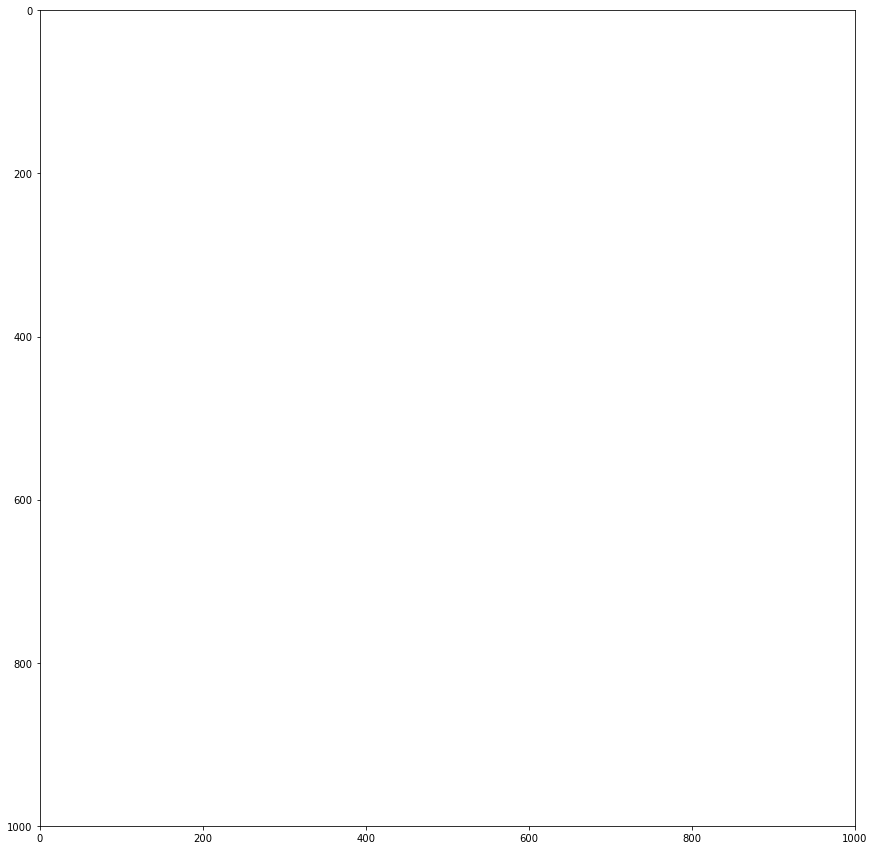

In [65]:
# f_x = 500 / np.tan(np.radians(fov) / 2)
# f_y = 500 / np.tan(np.radians(fov) / 2)

f_x = (N[0]/2) / np.tan(np.radians(fov)/2)
f_y = f_x

K = np.array([[f_x, 0,       0],
             [0,    f_y,     0],
             [0,    0,       1]])

P_MC = K @ T_MC @ np.concatenate((np.identity(3), -Xcam[:, None]/1e3), axis=1)

H_Ci = P_MC @ np.concatenate((H_Mi, np.tile(k.T[None, :, :], (len(H_Mi), 1, 1))), axis=1)

C_i = crater_representation(0, 0, major, minor, psi)
A_i = LA.inv(H_Ci.transpose(0, 2, 1)) @ C_i @ LA.inv(H_Ci)

def ellipse_from_matrix(x, y, matrix):
    A_ = matrix[0, 0]
    C_ = matrix[1, 1]
    G_ = matrix[2, 2]
    B_ = 2*matrix[1, 0]
    D_ = 2*matrix[2, 0]
    F_ = 2*matrix[2, 1]
    return A_*(x**2) + B_*x*y + C_*(y**2) + D_*x + F_*y + G_
x_plot = np.linspace(-1e5, 1e5, 500)
y_plot = np.linspace(-1e5, 1e5, 500)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention
ax.set_xlim(0, N[0])
ax.set_ylim(N[1], 0)
for A_ii in A_i[:100]:
    ax.contour(x_plot, y_plot, ellipse_from_matrix(x_plot, y_plot, A_ii), [0])


#### Unused

In [ ]:
x_quadric = np.concatenate((H_Mi, np.tile(k.T, (p_Mi.shape[0], 1, 1))), axis=1)
Q_star = x_quadric @ C_star @ x_quadric.transpose(0, 2, 1)
A_i_star = P_MC @ Q_star @ P_MC.T